In [31]:
import pandas as pd
import numpy as np
import random
from rdkit import Chem
from snn_model import get_loss_fn
import torch
from torch.utils.data import TensorDataset, DataLoader
from snntorch import spikegen, surrogate
import matplotlib.pyplot as plt
from utils import load_dataset_df, fp_generator, smile_to_fp, data_splitter, get_spiking_net
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score

import deepchem as dc


In [32]:
#!pip install pandas numpy rdkit torch snntorch matplotlib scikit-learn deepchem pubchempy

In [33]:
#https://github.com/chainer/chainer-chemistry/blob/master/chainer_chemistry/dataset/splitters/scaffold_splitter.py

#splitter = ScaffoldSplitter()
#tasks, datasets, transformers = dc.molnet.load_bbbp(splitter=splitter, featurizer="ECFP", reload=True)
#train, val, test = datasets

#### Load DataFrame

In [34]:
files = ['tox21.csv','sider.csv', 'BBBP.csv']
dt_file = files[2]
dirname = dt_file.strip('.csv')

df, targets = load_dataset_df(filename=dt_file)
print(targets)

target_name = targets[0]
df = df[[target_name, 'smiles']].dropna()


['p_np']


#### SMILE to Fingerprint

In [35]:
fp_types = [['morgan', 1024], ['maccs', 167], ['RDKit', 1024], ['pubchem', 881]]
fp_type, num_bits = fp_types[1]

fp_config = {"fp_type": fp_type,
             "num_bits": num_bits}
#num_bits = 237
print(fp_type, '-', num_bits)

maccs - 167


In [36]:
dtype = torch.float32
split = "scaffold"
dataset = None
if dirname != 'BBBP':
    split = "random"
    fp_array, target_array = smile_to_fp(df, fp_config=fp_config, target_name=target_name)
    # Create Torch Dataset
    fp_tensor = torch.tensor(fp_array, dtype=dtype)
    target_tensor = torch.tensor(target_array, dtype=dtype).long()

    dataset = TensorDataset(fp_tensor, target_tensor)

#### Loss Function

In [37]:
from sklearn.utils.class_weight import compute_class_weight

loss_types = ['cross_entropy', 'rate_loss', 'temporal_loss']
loss_type = loss_types[1]
print(loss_type)


rate_loss


#### Train Loop

In [38]:
net_types = ["SNN", "DSNN", "CSNN"]
net_type = net_types[0]
spike_grad = surrogate.sigmoid(slope=25)
net_config = {"input_size": num_bits,
              "num_hidden": 1024,
              "time_steps": 10,
              "spike_grad": spike_grad
              }

fast sigmoid / sigmoid
lr = 1e-5 ou -6, com 500-1000 epochs
batch size 16
batches devem incluir pos e neg samples
Adamax

experimentar com Tox21 NR-AR
temporal coding se não aumentar com rate coding

ver oversampling 

In [39]:
lr=1e-4 #default was e5-5
iterations = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
train_config = {"num_epochs": 100,
                "batch_size": batch_size,
                "device": device,
                "loss_type": loss_type,
                "loss_fn": None,
                'dtype': dtype,
                'num_steps': net_config['time_steps']
                }
results = [[], [], [], [], [], []]

In [40]:
from rdkit import RDLogger

# Disable RDKit logging
RDLogger.DisableLog('rdApp.*')


In [41]:
for iter in range(iterations):
    print(f"Iteration:{iter + 1}/{iterations}")
    random.seed(iter+1)

    net, train_net, test_net = get_spiking_net(net_type, net_config)
    net = net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0)
    #experimentar weight decay = 1e-4 e subir (pouco, 1e-3)

    # DATA SPLIT
    train, val, test = data_splitter(df, target_name, split=split, dataset=dataset, fp_config=fp_config, seed=iter+1, dtype=dtype)
    _, train_label = train[:]
    _, val_label = val[:]
    _, test_label = test[:]
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

    # LOSS FN
   #class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=np.array(train_label))
    #class_weights[0], class_weights[1] = class_weights[1], class_weights[0]
    #class_weights[0] += 5
    #class_weights = torch.tensor(class_weights, dtype=torch.float)
    class_weights = None
    train_config["loss_fn"] = get_loss_fn(loss_type=loss_type, class_weights=class_weights)

    # TRAINING
    print("TRAINING")
    net, loss_hist, val_acc_hist, val_auc_hist = train_net(net=net, optimizer=optimizer, train_loader=train_loader, val_loader=val_loader, train_config=train_config)

    # TESTING
    print("ESTING")
    all_preds, all_targets = test_net(net, device, test_loader)

    # METRICS
    accuracy = accuracy_score(all_targets, all_preds)
    auc_roc = roc_auc_score(all_targets, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_targets, all_preds).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    f1 = f1_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds)

    results[0].append(accuracy)
    results[1].append(auc_roc)
    results[2].append(sensitivity)
    results[3].append(specificity)
    results[4].append(f1)
    results[5].append(precision)


Iteration:1/1


TRAINING
Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10
Epoch:11
Epoch:12
Epoch:13
Epoch:14
Epoch:15
Epoch:16
Epoch:17
Epoch:18
Epoch:19
Epoch:20
Epoch:21
Epoch:22
Epoch:23
Epoch:24
Epoch:25
Epoch:26
Epoch:27
Epoch:28
Epoch:29
Epoch:30
Epoch:31
Epoch:32
Epoch:33
Epoch:34
Epoch:35
Epoch:36
Epoch:37
Epoch:38
Epoch:39
Epoch:40
Epoch:41
Epoch:42
Epoch:43
Epoch:44
Epoch:45
Epoch:46
Epoch:47
Epoch:48
Epoch:49
Epoch:50
Epoch:51
Epoch:52
Epoch:53
Epoch:54
Epoch:55
Epoch:56
Epoch:57
Epoch:58
Epoch:59
Epoch:60
Epoch:61
Epoch:62
Epoch:63
Epoch:64
Epoch:65
Epoch:66
Epoch:67
Epoch:68
Epoch:69
Epoch:70
Epoch:71
Epoch:72
Epoch:73
Epoch:74
Epoch:75
Epoch:76
Epoch:77
Epoch:78
Epoch:79
Epoch:80
Epoch:81
Epoch:82
Epoch:83
Epoch:84
Epoch:85
Epoch:86
Epoch:87
Epoch:88
Epoch:89
Epoch:90
Epoch:91
Epoch:92
Epoch:93
Epoch:94
Epoch:95
Epoch:96
Epoch:97
Epoch:98
Epoch:99
Epoch:100
ESTING


#### Smoothed Loss

[0.505526602268219, 0.5345244407653809, 0.5278380513191223, 0.5590880513191223, 0.5544615983963013]


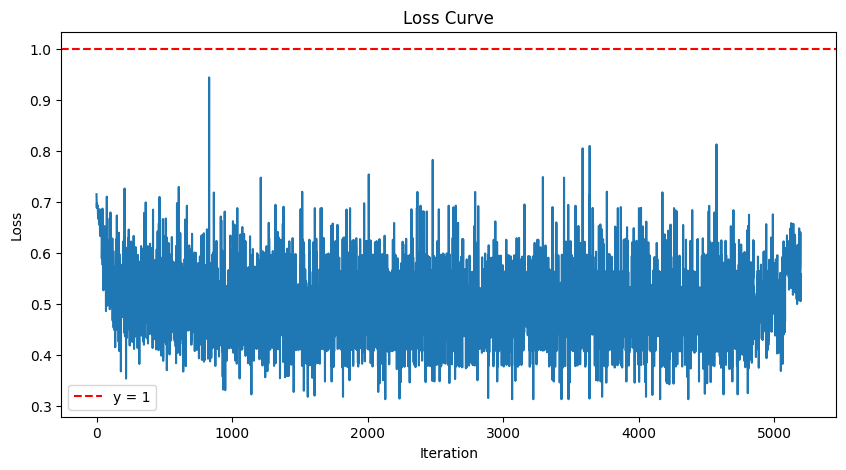

In [42]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from statsmodels.nonparametric.smoothers_lowess import lowess

print(loss_hist[len(loss_hist) - 5:len(loss_hist)])

fig = plt.figure(facecolor="w", figsize=(10, 5))
#plt.plot(np.convolve(loss_hist, np.ones(30)/30, mode='valid'))
#plt.plot(savgol_filter(loss_hist, window_length=100, polyorder=3))
#plt.plot(lowess(loss_hist, np.arange(len(loss_hist)), frac=0.1)[:, 1])
#plt.plot(gaussian_filter1d(loss_hist, sigma=6))
plt.plot(loss_hist)
plt.axhline(y=1, color='r', linestyle='--', label='y = 1')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [43]:
# Validation Set
# ROC auc plot every epochs


#### Save Metrics

In [44]:
metrics_np = np.zeros(12)

for i, metric in enumerate(results):
    metrics_np[i*2] = np.round(np.mean(metric), 3)
    metrics_np[i*2+1] = np.round(np.std(metric), 3)

# Print Results
print(f"Accuracy:  {metrics_np[0]:.3f} ± {metrics_np[1]:.3f}")
print(f"AUC ROC: {metrics_np[2]:.3f} ± {metrics_np[3]:.3f}")
print(f"Sensitivity: {metrics_np[4]:.3f} ± {metrics_np[5]:.3f}")
print(f"Specificity: {metrics_np[6]:.3f} ± {metrics_np[7]:.3f}")

metric_names = ['Acc', 'AUC', 'Sn', 'Sp', 'F1', 'Precision']
metrics_np = metrics_np.reshape(1, -1)
columns = []
for name in metric_names:
    columns.extend([f'Mean {name}', f'Std {name}'])


df_metrics = pd.DataFrame(metrics_np, columns=columns)
num_hidden = net_config['num_hidden']
time_steps = train_config['num_steps']
num_epochs = train_config['num_epochs']

if dirname == 'BBBP':
    if net_type == 'CSNN':
        filename = f"results\\{dirname}\\{net_type}_{fp_type}_{num_bits}_{time_steps}_lr{lr}_e{num_epochs}_{loss_type}_{split}.csv"
    else:
        filename = f"results\\{dirname}\\{net_type}_{fp_type}_{num_bits}_{num_hidden}_{time_steps}_lr{lr}_e{num_epochs}_{loss_type}_{split}.csv"
else:
    filename = f"results\\{dirname}\\{target_name}_{net_type}_{fp_type}_{num_bits}_{num_hidden}_{time_steps}_lr{lr}_e{num_epochs}_{loss_type}_{split}.csv"


df_metrics.to_csv(filename, index=False)

print(filename)

Accuracy:  0.521 ± 0.000
AUC ROC: 0.500 ± 0.000
Sensitivity: 1.000 ± 0.000
Specificity: 0.000 ± 0.000
results\BBBP\SNN_maccs_167_1024_10_lr0.0001_e100_rate_loss_scaffold.csv
